In [1]:
# There seem to be issues with the ibm provider package, so I am temporarily using the deprecated IBMQ one
#from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Options
#from qiskit import IBMQ
# This is until the problem is resolved. https://github.com/Qiskit/qiskit-ibm-provider/issues/604 There are a lot of issues with transpiling and I believe with network timeouts/responses too
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import qiskit.algorithms.optimizers
import sklearn.model_selection
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import pandas as pd
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sb
import os.path
from datetime import datetime
from math import ceil

Code is based on [the tutorial found here](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html#Regression).
**Data preparation**

In [2]:
from IPython.core.display import Markdown
from sklearn.utils import Bunch

data_source: Bunch = fetch_covtype(data_home="./data")
Markdown(data_source.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30Ã—30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional argument 'as_frame' is
set to 'True', it will return ``data`` and ``target`` as pandas
data frame, and there will be an additional member ``frame`` as well.
The dataset will be downloaded from the web if necessary.


We define the configuration of our training session here for clarity.

In [3]:
data_frac = 0.002	# The fraction of data used for training/testing from the total dataset.
train_frac = 0.8	# The proportion of the sample used for training, with the rest reserved for testing.
num_features = 8	# The data has many features to train on, so we use PCA to reduce it to a manageable amount
batch_size = 512	# We train the model with batches of data, and this is the maximum size of a given batch
iterations = 20		# The number of times a batch is fitted to the model
shots = 256			# The number of times to run a set of circuits for
opt_level = 3		# The level of optimization for the circuits
res_level = 0		# The level of resilience hardening for the circuits

In [4]:
data_frame = pd.DataFrame(data=data_source.data, columns=data_source.feature_names)
#data_frame.drop(data_frame.iloc[:, -44:], axis=1, inplace=True)
data_frame["Cover_Type"] = pd.Series(data_source.target)-1
data_frame = data_frame.sample(frac=data_frac)
display(data_frame)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
485220,3844.0,11.0,8.0,984.0,395.0,4746.0,211.0,223.0,148.0,2810.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6
564072,2555.0,141.0,3.0,0.0,0.0,934.0,225.0,238.0,149.0,1565.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
286233,2899.0,290.0,7.0,42.0,4.0,1994.0,200.0,239.0,178.0,708.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
168072,3083.0,45.0,8.0,201.0,18.0,5218.0,223.0,223.0,135.0,2670.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
512943,3179.0,299.0,17.0,67.0,6.0,757.0,170.0,231.0,200.0,2455.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221849,3229.0,31.0,13.0,60.0,1.0,2862.0,216.0,212.0,129.0,2687.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
281653,2942.0,131.0,16.0,234.0,40.0,1670.0,244.0,230.0,111.0,713.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8731,2813.0,248.0,19.0,285.0,74.0,1690.0,177.0,250.0,209.0,2220.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
342535,2970.0,48.0,11.0,30.0,9.0,2370.0,224.0,216.0,124.0,2174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Separate the features and the labels (which is our target). We also preprocess the features and labels (normalizing and categorizing respectively)

In [5]:
features = data_frame.iloc[:, 0:-1].values
features = PCA(n_components=num_features).fit_transform(features)
labels = data_frame.loc[:, "Cover_Type"].values
features = StandardScaler().fit_transform(features)
labels = OrdinalEncoder().fit_transform(labels.reshape(-1,1))[:,0]
display(features, features.shape)
display(labels, labels.shape)
#sb.stripplot(data=data_frame.sample(frac=0.05), y="Cover_Type", hue="Cover_Type")

array([[ 1.58625977, -0.53605794,  3.38766469, ..., -5.28413246,
        -1.24589617, -0.67626688],
       [-0.83387835,  0.37178656, -1.35590598, ...,  0.22712721,
        -0.30326105, -1.38924462],
       [-0.56191025, -0.74259831, -0.47194542, ...,  0.25045036,
        -0.07096406, -0.57537607],
       ...,
       [-0.21812206,  0.48189627, -0.26301739, ..., -0.43165995,
        -1.50336887, -0.53696233],
       [ 0.11775551,  0.13316929, -0.42029042, ..., -0.2185063 ,
        -0.2720212 ,  0.00900746],
       [-0.58362449, -0.07011329, -1.2661968 , ..., -0.19547246,
         0.42859064,  0.28661665]])

(1162, 8)

array([6., 1., 1., ..., 4., 0., 1.])

(1162,)

We separate the now preprocessed data into a training set and a test set with a 80:20 split.

In [6]:
train_features, test_features, train_labels, test_labels = sklearn.model_selection.train_test_split(
	features,
	labels,
	train_size=train_frac
)
display(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

(929, 8)

(929,)

(233, 8)

(233,)

We also separate the data into batches for more time-efficient learning

In [7]:
from sklearn.utils import gen_batches

train_slices = gen_batches(train_features.shape[0], batch_size)

**Creating the QNN**
We now will make the QNN to process our data.

In [8]:
circuit = QuantumCircuit(num_features)
feature_map = ZZFeatureMap(num_features, reps=2)
ansatz = EfficientSU2(num_features, reps=2)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

In [9]:
def interpret(x):
	return x%7

service: QiskitRuntimeService = QiskitRuntimeService(
	channel='ibm_quantum',
	instance='ibm-q-asu/main/pi-deluca',
)

options = Options()
options.execution.shots = shots
options.optimization_level = opt_level
options.resilience_level = res_level
#backend = service.least_busy(min_num_qubits=num_features, filters=lambda b: b.configuration().simulator == True)
backend = service.get_backend("simulator_statevector")
print(backend.name)
circuit = transpile(circuits=circuit, backend=backend)
custom_sampler = Sampler(session=backend, options=options)

sampler = SamplerQNN(sampler=custom_sampler,
					 circuit=circuit,
					 input_params=feature_map.parameters,
					 weight_params=ansatz.parameters,
					 interpret=interpret,
					 output_shape=7
					 )
sampler.input_gradients = True

simulator_statevector


In [10]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.clf()
def callback_graph(weights, obj_func_eval):
	clear_output(wait=True)
	objective_func_vals.append(obj_func_eval)
	plt.title("Objective function value against iteration")
	plt.xlabel("Iteration")
	plt.ylabel("Objective function value")
	plt.plot(range(len(objective_func_vals)), objective_func_vals)
	plt.show()

<Figure size 1200x600 with 0 Axes>

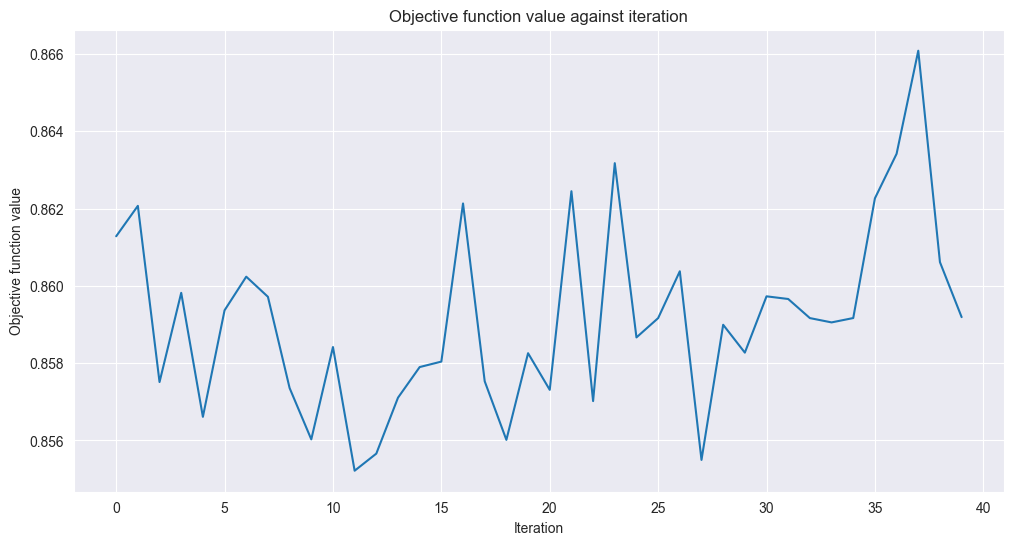

Model trained at 2023-06-20 20:46:19.698119, for a total time of 3:43:04.648344


In [11]:
from qiskit_machine_learning import QiskitMachineLearningError
classifier = NeuralNetworkClassifier(
	sampler,
	one_hot=True,
	optimizer=qiskit.algorithms.optimizers.COBYLA(maxiter=iterations),
	callback=callback_graph,
	warm_start=True
)
plt.clf()
start = datetime.now()
display(f"Model started training at {str(start)}")
for chunk in train_slices:
	"""
	try:
		classifier.fit(train_features[chunk], train_labels[chunk])
	except QiskitMachineLearningError as e:
		display(f"Error in slice {chunk}: {e.message}")
		display(f"{e.__traceback__}")
	else:
		# We save our current progress after each round of training, in case it errors out
		classifier.save("covertypemodel_test1.model")
	"""

	classifier.fit(train_features[chunk], train_labels[chunk])
	#classifier.save("covertypemodel_test1.model")

finish = datetime.now()
print(f"Model trained at {str(finish)}, for a total time of {str(finish-start)}")

In [12]:
testing_score = classifier.score(test_features, test_labels)
print(f"Test dataset score:     {testing_score:.6f}")
training_score = classifier.score(train_features, train_labels)
print(f"Training dataset score: {training_score:.6f}")

Test dataset score:     0.145923
Training dataset score: 0.152853
